In [101]:
import pickle 

with open('yk_values_dataframe.pkl', 'rb') as file:
    yk_values = pickle.load(file)

with open('ty_values_dataframe.pkl', 'rb') as file:
    ty_values = pickle.load(file)

with open('luna_values_dataframe.pkl', 'rb') as file:
    luna_values = pickle.load(file)

In [102]:
print("YK: ", yk_values.shape)
print("TY: ", ty_values.shape)
print("Luna: ", luna_values.shape)

YK:  (69579, 1025)
TY:  (79785, 1402)
Luna:  (10746, 3370)


In [103]:
import pandas as pd
import numpy as np

df = pd.concat([yk_values, ty_values, luna_values], axis=1).T
df.shape

(5797, 79785)

In [198]:
df

,Name,Distribution Type,1,2,3,4,5,6,7,8,...,79774,79775,79776,79777,79778,79779,79780,79781,79782,79783
0,temperature,functional,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Device_Test_Time,longtail,22332.0,11976.0,11920.0,9224.0,11936.0,11914.0,11893.0,11904.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Part_Id,longtail,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,g2bist_efuse_blank_read_f_:Functional[1],functional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tdf_50k_2_f_:Functional[1],functional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3365,f_nvmXWritePatvformRdtyperdNvm1_x_x_vhsform__r...,longtail,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3366,f_nvmXWritePatvformRdtyperdNvm1_x_x_vhsform__r...,functional,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3367,f_nvmXWritePatvformRdtyperdRedenNvm1_x_x_vhsfo...,functional,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3368,f_nvmXWritePatvformRdtyperdRedenNvm1_x_x_vhsfo...,discrete,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
df_values = df.iloc[:, 2:] # each row represents a test with all its values
df_values = df_values.reset_index().drop(columns='index')

df_target = df.iloc[:, :2] # each row is test name and distribution
df_target = df_target.reset_index().drop(columns='index')

In [205]:
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import IsolationForest

def extract_qq_features(data, theoretical_distribution='norm'):
    features = []
    for index, row in data.iterrows():
        #row = row.dropna()
        row = pd.to_numeric(row, errors='coerce').dropna().values
        if len(row) < 2:
            features.append({
                'Mean_Deviation': np.nan,
                'Max_Deviation': np.nan,
                'Std_Deviation': np.nan,
                'Mean_Abs_Deviation': np.nan,
                'Median_Abs_Deviation': np.nan,
                'Q1_Deviation': np.nan,
                'Q5_Deviation': np.nan,
                'Q25_Deviation': np.nan,
                'Q50_Deviation': np.nan,
                'Q75_Deviation': np.nan,
                'Q95_Deviation': np.nan,
                'Q99_Deviation': np.nan,
                'AD_Stat': np.nan,
                'Line_Fit_R_Squared': np.nan,
                'Isolation Forest': np.nan
            })
            continue

        qq_plot = stats.probplot(row, dist=theoretical_distribution, plot=None)
        quantiles_theoretical = qq_plot[0][0]  # Theoretical quantiles
        quantiles_empirical = qq_plot[0][1]    # Empirical quantiles
        deviations = np.array(quantiles_empirical) - np.array(quantiles_theoretical)
        mean_abs_deviation = np.mean(np.abs(deviations))
        median_abs_deviation = np.median(np.abs(deviations))
        ad_stat = stats.anderson(row, dist=theoretical_distribution).statistic
        coeffs = np.polyfit(quantiles_theoretical, quantiles_empirical, 1)
        line_fit_r_squared = np.corrcoef(quantiles_theoretical, quantiles_empirical)[0, 1]**2

        iso_forest = IsolationForest(contamination='auto', random_state=42)
        df_reshaped = row.reshape(-1, 1)
        iso_forest.fit(df_reshaped)
        anomaly_scores = iso_forest.score_samples(df_reshaped)
        anomaly_scores = np.array(anomaly_scores)
        negative_scores = anomaly_scores[anomaly_scores < 0]
        iso_forest_anomaly = negative_scores.sum()

        features.append({
            'Mean_Deviation': np.mean(deviations),
            'Max_Deviation': np.max(deviations),
            'Std_Deviation': np.std(deviations),
            'Mean_Abs_Deviation': mean_abs_deviation,
            'Median_Abs_Deviation': median_abs_deviation,
            'Q1_Deviation': np.abs(np.percentile(row, 1) - np.percentile(quantiles_theoretical, 1)),
            'Q5_Deviation': np.abs(np.percentile(row, 5) - np.percentile(quantiles_theoretical, 5)),
            'Q25_Deviation': np.abs(np.percentile(row, 25) - np.percentile(quantiles_theoretical, 25)),
            'Q50_Deviation': np.abs(np.percentile(row, 50) - np.percentile(quantiles_theoretical, 50)),
            'Q75_Deviation': np.abs(np.percentile(row, 75) - np.percentile(quantiles_theoretical, 75)),
            'Q95_Deviation': np.abs(np.percentile(row, 95) - np.percentile(quantiles_theoretical, 95)),
            'Q99_Deviation': np.abs(np.percentile(row, 99) - np.percentile(quantiles_theoretical, 99)),
            'AD_Stat': ad_stat,
            'Line_Fit_R_Squared': line_fit_r_squared,
            'Isolation Forest': iso_forest_anomaly
        })
    return pd.DataFrame(features)


In [206]:
features_df = extract_qq_features(df_values)

/Users/snowy/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/stats/_morestats.py:1948: RuntimeWarning: invalid value encountered in divide
  w = (y - xbar) / s
/Users/snowy/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/snowy/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/snowy/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/stats/_morestats.py:1948: RuntimeWarning: invalid value encountered in divide
  w = (y - xbar) / s
/Users/snowy/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/snowy/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :

In [142]:
features_df

,Mean_Deviation,Max_Deviation,Std_Deviation,Mean_Abs_Deviation,Median_Abs_Deviation,Q1_Deviation,Q5_Deviation,Q25_Deviation,Q50_Deviation,Q75_Deviation,Q95_Deviation,Q99_Deviation,AD_Stat,Line_Fit_R_Squared
0,2.500000e+01,29.265735,0.999939,25.000000,25.000000,27.325987,26.644768,25.674474,25.0,24.325526,23.355232,22.674013,NaN,NaN
1,1.611945e+04,26674.230146,1142.707783,16119.452606,16407.997442,9944.325987,15406.644768,15980.674474,16408.0,16486.325526,16820.355232,16902.674013,10929.220566,0.398494
2,7.088813e+03,19460.734265,4963.807017,7088.813185,6447.999964,49.325987,259.644768,2865.674474,6448.0,10795.325526,15984.555232,18766.914013,756.283654,0.955378
3,-1.000000e+00,2.174731,0.997022,1.165498,1.049797,1.300306,0.638456,0.326671,1.0,1.673329,2.638456,3.300306,NaN,NaN
4,-7.500000e-01,-0.001851,0.478511,0.750000,0.853479,0.023060,0.107895,0.532069,1.0,1.217931,1.042105,1.006940,0.826838,0.614379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5792,1.010798e+00,11.171712,0.998744,1.164592,1.041076,3.324022,2.644300,1.674390,1.0,0.325610,0.644300,1.324022,4090.864700,0.017857
5793,-2.539779e-16,3.828288,0.999665,0.797756,0.674536,2.324022,1.644300,0.674390,0.0,0.674390,1.644300,2.324022,NaN,NaN
5794,-2.539779e-16,3.828288,0.999665,0.797756,0.674536,2.324022,1.644300,0.674390,0.0,0.674390,1.644300,2.324022,NaN,NaN
5795,1.000372e+00,4.828288,0.998571,1.166143,1.050272,3.324022,2.644300,1.674390,1.0,0.325610,0.644300,1.324022,4148.426971,0.003375


In [147]:
mask = features_df.isnull().any(axis=1)
df_target_dropped = df_target[~mask] # drop corresponding test target with null features
features_df_dropped = features_df.dropna() # drop test with null features

In [160]:
features_df['AD_Stat'].fillna(0, inplace=True) 
features_df['Line_Fit_R_Squared'].fillna(0, inplace=True)

features_df = features_df.dropna()
df_target= df_target.drop(features_df[features_df.isna().any(axis=1)].index, errors='ignore')

In [169]:
from sklearn.model_selection import train_test_split

columns_to_drop = ['Target', 'Name', 'Distribution Type', 'Target_Encoded']
X = features_df
y = df_target['Distribution Type'].apply(lambda x: 1 if x in ['outlier', 'longtail'] else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [180]:
y.value_counts()

0    4148
1    1646
Name: Distribution Type, dtype: int64

In [171]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [172]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9551337359792925
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       827
           1       0.93      0.91      0.92       332

    accuracy                           0.96      1159
   macro avg       0.95      0.94      0.94      1159
weighted avg       0.95      0.96      0.95      1159



In [174]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

from sklearn.ensemble import RandomForestClassifier

model_smote = RandomForestClassifier()

model_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = model_smote.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("Classification Report:\n", classification_report(y_test, y_pred_smote))

Accuracy: 0.9559965487489215
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       827
           1       0.92      0.93      0.92       332

    accuracy                           0.96      1159
   macro avg       0.95      0.95      0.95      1159
weighted avg       0.96      0.96      0.96      1159



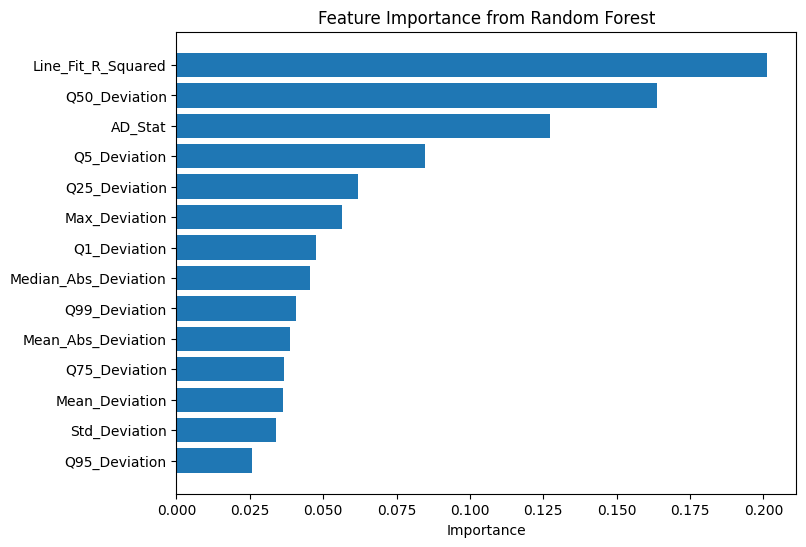

In [175]:
import pandas as pd
import matplotlib as plt

importances = model_smote.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.show()

In [185]:
# for positive class (outlier/longtail)
unrecalled_mask = (y_test == 1) & (y_pred_smote != 1)
unrecalled_points = X_test[unrecalled_mask]

recalled_mask = (y_test == 1) & (y_pred_smote == 1)
recalled_points = X_test[recalled_mask]

# # for negative class (other distributions)
negative_points = features_df_dropped[df_target_dropped == 0]

In [191]:
unrecalled_points

,Mean_Deviation,Max_Deviation,Std_Deviation,Mean_Abs_Deviation,Median_Abs_Deviation,Q1_Deviation,Q5_Deviation,Q25_Deviation,Q50_Deviation,Q75_Deviation,Q95_Deviation,Q99_Deviation,AD_Stat,Line_Fit_R_Squared
4942,9.437184e+06,9.437187e+06,1.062303,9.437184e+06,9.437184e+06,9.437186e+06,9.437186e+06,9.437185e+06,9.437184e+06,9.437183e+06,9.437182e+06,9.437182e+06,4092.917294,0.009606
394,-4.193674e-08,4.251160e+00,0.999935,7.978614e-01,6.744853e-01,2.325963e+00,1.644762e+00,6.744732e-01,4.200000e-08,6.744733e-01,1.644762e+00,2.325963e+00,95.249805,0.995305
5117,-9.999000e+03,-9.995172e+03,0.999665,9.999000e+03,9.999000e+03,9.996676e+03,9.997356e+03,9.998326e+03,9.999000e+03,9.999674e+03,1.000064e+04,1.000132e+04,0.000000,0.000000
502,9.900281e+01,1.597488e+02,12.969682,9.900281e+01,9.899665e+01,7.332596e+01,7.864476e+01,8.867447e+01,9.900000e+01,1.103255e+02,1.193552e+02,1.226740e+02,394.064011,0.979308
3048,-1.131156e-07,3.828309e+00,0.999664,7.977559e-01,6.744626e-01,2.324020e+00,1.644298e+00,6.743893e-01,7.834024e-08,6.743894e-01,1.644299e+00,2.324021e+00,30.138472,0.986899
811,6.006209e+00,9.894247e+00,0.929433,6.006209e+00,6.006907e+00,8.165485e+00,7.534154e+00,6.633831e+00,6.006907e+00,5.379278e+00,4.476201e+00,3.843283e+00,1.963883,0.999778
4378,8.257171e-05,3.828362e+00,0.999662,7.977544e-01,6.744520e-01,2.324099e+00,1.644378e+00,6.744706e-01,8.245191e-05,6.743056e-01,1.644213e+00,2.323933e+00,7.777412,0.997209
3924,4.741931e+06,5.727290e+06,204698.626215,4.741931e+06,4.744788e+06,4.289482e+06,4.409300e+06,4.601007e+06,4.744788e+06,4.888569e+06,5.080276e+06,5.224058e+06,7.594642,0.997613
4287,-2.539779e-16,3.828288e+00,0.999665,7.977564e-01,6.745363e-01,2.324022e+00,1.644300e+00,6.743898e-01,0.000000e+00,6.743898e-01,1.644300e+00,2.324022e+00,0.000000,0.000000
4486,-9.999000e+03,-9.995172e+03,0.999665,9.999000e+03,9.999000e+03,9.996676e+03,9.997356e+03,9.998326e+03,9.999000e+03,9.999674e+03,1.000064e+04,1.000132e+04,0.000000,0.000000


In [188]:
recalled_points.describe()

,Mean_Deviation,Max_Deviation,Std_Deviation,Mean_Abs_Deviation,Median_Abs_Deviation,Q1_Deviation,Q5_Deviation,Q25_Deviation,Q50_Deviation,Q75_Deviation,Q95_Deviation,Q99_Deviation,AD_Stat,Line_Fit_R_Squared
count,3.080000e+02,3.080000e+02,3.080000e+02,3.080000e+02,3.080000e+02,3.080000e+02,3.080000e+02,3.080000e+02,3.080000e+02,3.080000e+02,3.080000e+02,3.080000e+02,308.000000,308.000000
mean,1.887636e+05,2.281576e+05,1.069921e+04,1.916203e+05,1.934916e+05,1.627347e+05,1.718477e+05,1.866338e+05,1.934913e+05,1.983080e+05,2.045217e+05,2.100172e+05,3610.429587,0.642415
std,1.204812e+06,1.291404e+06,1.075032e+05,1.204360e+06,1.220014e+06,1.104854e+06,1.127902e+06,1.187340e+06,1.220014e+06,1.238684e+06,1.250543e+06,1.257322e+06,7279.259709,0.409624
min,-9.998059e+03,-2.925382e+01,1.897429e-01,7.825506e-01,6.511232e-01,4.779487e-01,6.474871e-01,2.882439e-02,0.000000e+00,2.465128e-02,2.772250e-01,1.051892e-01,0.644066,0.001365
25%,-4.666564e-01,3.828444e+00,9.920884e-01,7.977544e-01,6.744605e-01,2.324022e+00,1.644300e+00,6.744073e-01,1.559005e-04,6.742270e-01,1.644122e+00,2.323833e+00,80.218581,0.072220
50%,1.570749e-04,4.264432e+00,9.996542e-01,9.363230e-01,7.596647e-01,2.326012e+00,1.645361e+00,6.754857e-01,5.061502e-01,9.774708e-01,1.920679e+00,2.615848e+00,324.154999,0.870857
75%,1.084999e+00,1.111773e+02,1.374981e+01,3.184270e+01,3.016717e+01,2.996002e+01,3.127461e+01,3.063277e+01,3.016862e+01,3.065298e+01,3.067316e+01,5.417549e+01,4148.799334,0.974212
max,9.437184e+06,9.437186e+06,1.826116e+06,9.437184e+06,9.437184e+06,9.437184e+06,9.437186e+06,9.437185e+06,9.437184e+06,9.437183e+06,9.437182e+06,9.437182e+06,30618.667897,0.999883


In [190]:
negative_points

,Mean_Deviation,Max_Deviation,Std_Deviation,Mean_Abs_Deviation,Median_Abs_Deviation,Q1_Deviation,Q5_Deviation,Q25_Deviation,Q50_Deviation,Q75_Deviation,Q95_Deviation,Q99_Deviation,AD_Stat,Line_Fit_R_Squared
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
